<a href="https://colab.research.google.com/github/susanth378/Credit_card_Classification_using_sklearn/blob/master/Credit_fraud_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 
In this exercise, will predict using various classifier models to see how each model works on credit fraud transactions dataset. This dataset is from kaggle and the features are scaled and the names of the attributes are not displayed due to privacy reasons. 

### Importing required libraries

In [0]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time
import collections

# Sklearn library 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model selection 

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbalanced_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings("ignore")



### Downloading data from Kaggle
1. Go to my account in kaggle, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

1) ! pip install -q kaggle

2) from google.colab import files

files.upload()

Choose the kaggle.json file that you downloaded

3) ! mkdir -p ~/.kaggle


! cp kaggle.json ~/.kaggle/

Make directory named kaggle and copy kaggle.json file there.

4) ! chmod 600 ~/.kaggle/kaggle.json 

Change the permissions of the file.

### For Downloading data 

Go to the dataset and copy API Command

! kaggle datasets download -d mlg-ulb/creditcardfraud

In [0]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sushdiv378","key":"6ec45a78552883014e7d7cdf932e3b59"}'}

In [0]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
! kaggle datasets download -d mlg-ulb/creditcardfraud

 89% 59.0M/66.0M [00:00<00:00, 63.3MB/s]
100% 66.0M/66.0M [00:00<00:00, 104MB/s] 


In [0]:
!mkdir data

In [9]:
! unzip creditcardfraud.zip -d data

Archive:  creditcardfraud.zip
  inflating: data/creditcard.csv     


# Analyzing the data
Now data has been downloaded and upzipped into data folder in colab, now we can load the dataset as we normally load.

Except for the transaction and amount all other columns are unknown due to privacy reasons. Also the unknown columns have been scaled already. The description of the data says that all the features went through a PCA transformation (Except for time and amount)

In [10]:
data_df = pd.read_csv('./data/creditcard.csv')
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


All the columns are scaled except amount and time, amount is in $

In [12]:
data_df.isnull().sum().max()

0

In [13]:
print('Number of columns' , len(data_df.columns))
data_df.columns

Number of columns 31


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

We have no null values, so no need of any missing value treatment...
And there are total of 31 columns

will see the distribution of labels

In [14]:
print('Not Fradulent', round(data_df['Class'].value_counts()[0]/len(data_df) * 100,2), '% of the dataset - ',round(data_df['Class'].value_counts()[0] ))
print('Fraudulent', round(data_df['Class'].value_counts()[1]/len(data_df) * 100,2), '% of the dataset - ',round(data_df['Class'].value_counts()[1]))

Not Fradulent 99.83 % of the dataset -  284315
Fraudulent 0.17 % of the dataset -  492


We can see the dataset is high imbalanced since fraudulent transactions happens rare .. but our need is to precisely capture them to stop fradulent transactions, so we should use oversampling techniques to make the dataset balanced.

Text(0.5, 1.0, 'Fraud - 1, No Fraud - 0')

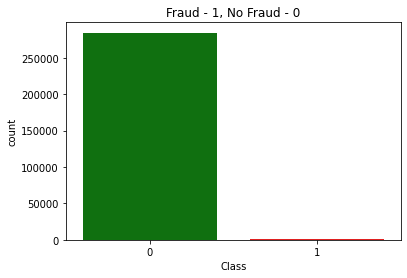

In [15]:
sns.countplot('Class', data = data_df, palette= ['g','r'])
plt.title('Fraud - 1, No Fraud - 0')

We will here scale the amount and time column as well and create a subsample dataset where we will have 50/50 distribution of fraud and non fradulent transaction. We shall randomly select non fradulent transaction

In [0]:
scaler = RobustScaler() # Not prone to outliers

data_df['scaled_amount'] = scaler.fit_transform(data_df['Amount'].values.reshape(-1,1))
data_df['scaled_time'] = scaler.fit_transform(data_df['Time'].values.reshape(-1,1))

data_df.drop(['Time','Amount'], axis=1, inplace=True)

# Moving these two columns to the start of the dataframe
scaled_amount = data_df['scaled_amount']
scaled_time = data_df['scaled_time']

data_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data_df.insert(0, 'scaled_amount', scaled_amount)
data_df.insert(1, 'scaled_time', scaled_time)

In [17]:
data_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting the data

Before oversampling or undersampling the data we need to split the data into train, val and test sets because we need our model to train on the balanced set to overcome overfitting but our model to need to predict for the real scenario which will be imbalanced

In [0]:
Y = data_df.pop('Class')

In [0]:
X = data_df.copy()

In [0]:
X_train_org, X_test_org, Y_train_org, Y_test_org  = train_test_split(X,Y,random_state = 143, test_size = 0.2)

In [21]:
Y_test_org.shape

(56962,)

# UnderSampling Technique

Since we have 385 fraud samples we will also randomly take 385 non fraud samples. This can be done by shuffle and taking 385 samples from non fraud or we can use Nearmiss technique, here going with latter 

In [22]:
print('Before undersampling dataset size' , Counter(Y_train_org))
nm  = NearMiss()
X_under, Y_under = nm.fit_resample(X_train_org,Y_train_org)
print('After Undersampling dataset size', Counter(Y_under))

Before undersampling dataset size Counter({0: 227460, 1: 385})
After Undersampling dataset size Counter({0: 385, 1: 385})


In [0]:
X_under_df, Y_under_df = pd.DataFrame(X_under, columns= X_train_org.columns), pd.DataFrame(Y_under, columns= ['Class'])

We can see the correlation matrix for original set and undersampled set

Text(0.5, 1.0, 'Balanced dataset correlation')

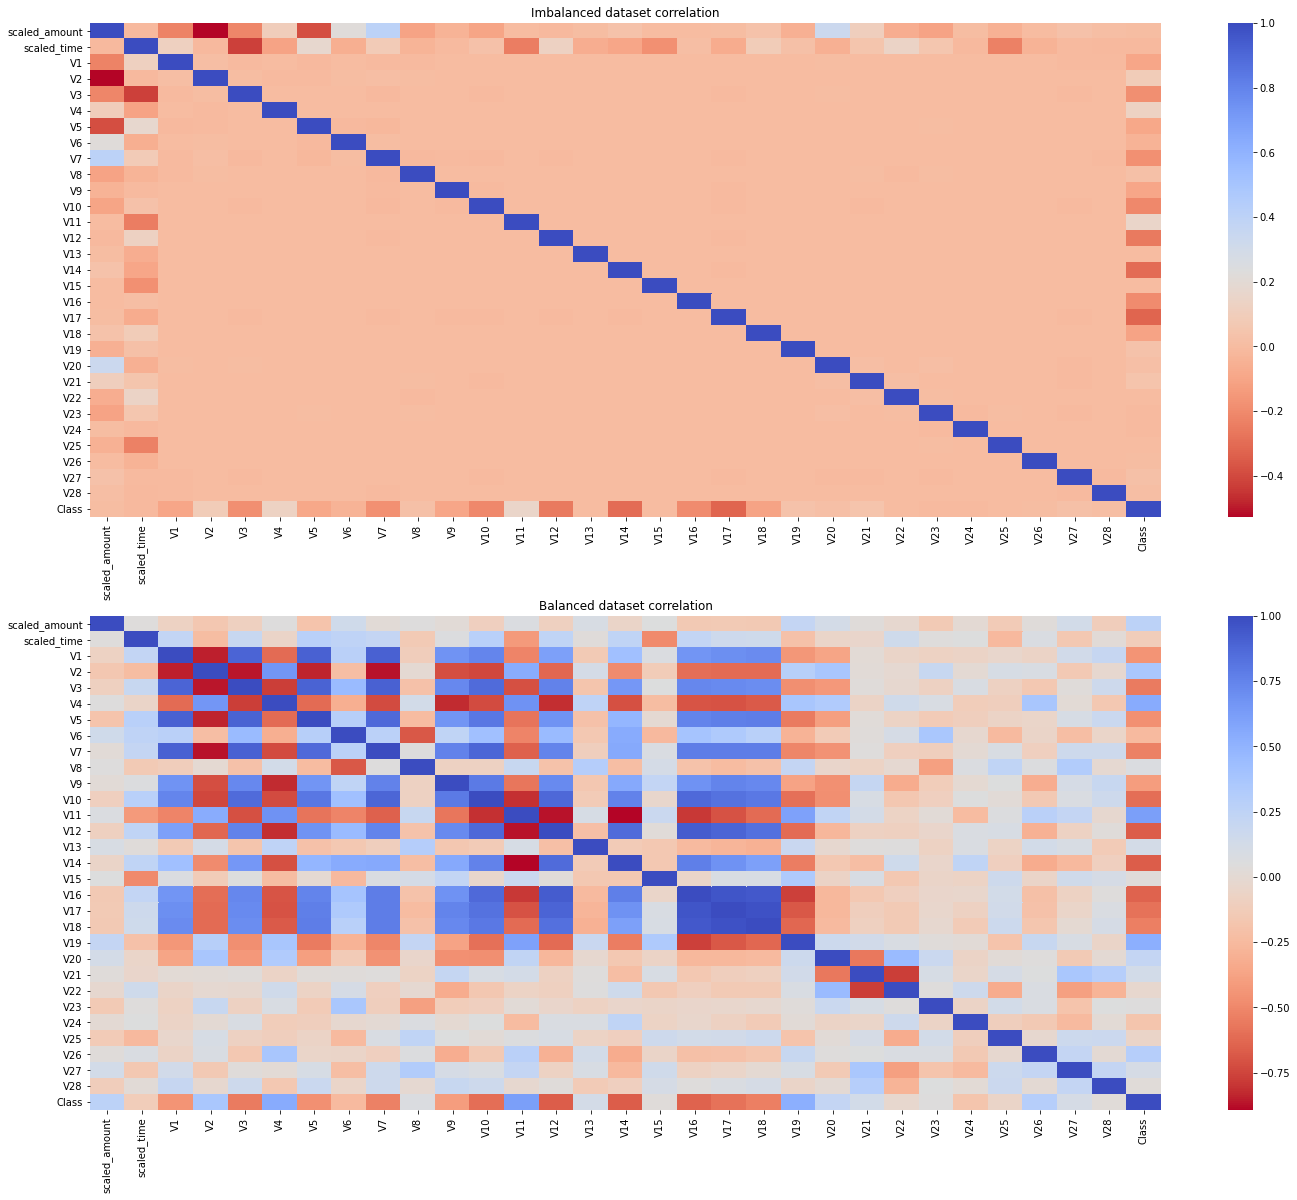

In [24]:
f , (ax1,ax2) = plt.subplots(2,1, figsize = (24,20))
train_data_org = pd.concat([X_train_org,Y_train_org], axis = 1)
under_data = pd.concat([X_under_df,Y_under_df], axis = 1)
# Original dataset correlation
corr_org = train_data_org.corr()
sns.heatmap(corr_org, cmap = 'coolwarm_r', ax = ax1)
ax1.set_title('Imbalanced dataset correlation')

# Balanced dataset correlation

corr_balanced = under_data.corr()
sns.heatmap(corr_balanced, cmap = 'coolwarm_r', ax = ax2 )
ax2.set_title('Balanced dataset correlation')

Here we can see correlation for balanced data is much more useful than the correlation on original data since we have high non fraud values(0) which doesnt explain correlation well

Now we can see if there are any outliers, V10, V12 and V14 are the features which are negatively correlated with fraud cases and V11 and V4 are positively related..so we shall examine these...

Text(0.5, 1.0, 'V4 feature, Positively correlated with Fraud')

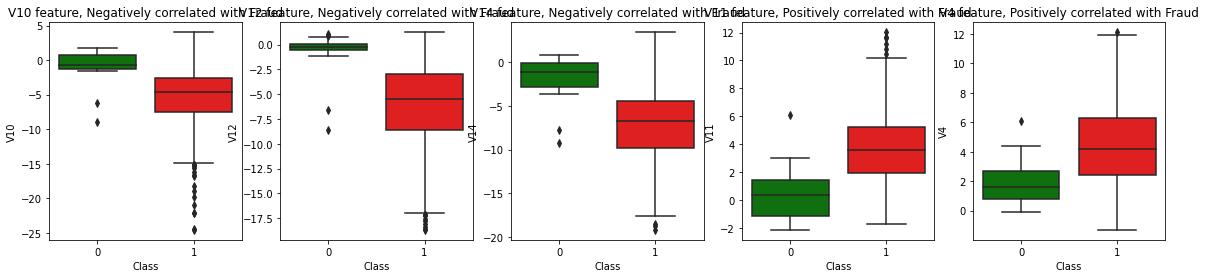

In [25]:
f, ax = plt.subplots(1,5, figsize = (20,4))

sns.boxplot(x= 'Class', y= 'V10' ,data= under_data, palette=['g','r'] , ax= ax[0])
ax[0].set_title('V10 feature, Negatively correlated with Fraud')

sns.boxplot(x= 'Class', y= 'V12' ,data= under_data, palette=['g','r'] , ax= ax[1])
ax[1].set_title('V12 feature, Negatively correlated with Fraud')

sns.boxplot(x= 'Class', y= 'V14' ,data= under_data, palette=['g','r'] , ax= ax[2])
ax[2].set_title('V14 feature, Negatively correlated with Fraud')

sns.boxplot(x= 'Class', y= 'V11' ,data= under_data, palette=['g','r'] , ax= ax[3])
ax[3].set_title('V11 feature, Positively correlated with Fraud')

sns.boxplot(x= 'Class', y= 'V4' ,data= under_data, palette=['g','r'] , ax= ax[4])
ax[4].set_title('V4 feature, Positively correlated with Fraud')

By info from box plot we can see that V10 might have some outliers, will try to filter outliers from V10 with IQR threshold

IQR = Q3- Q1
threshold setting can be lower = Q1 - 1.5IQR, higher = Q3 + 1.5 IQR , we can consider 1.5 as a variable and can tune this hyperparameter

In [26]:
# removing outliers
v10_fraud = under_data['V10'].loc[under_data['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
# IQR = q75 - q25
v10_iqr = q75 - q25


v10_threshold = v10_iqr * 1.8
v10_lower, v10_upper = q25 - v10_threshold, q75 + v10_threshold
print('Threshold: {}'.format(v10_threshold))
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Number of Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

print('Before removing outliers', len(under_data))
under_data = under_data.drop(under_data[(under_data['V10'] > v10_upper) | (under_data['V10'] < v10_lower)].index)

print('After removing outliers', len(under_data))

Threshold: 8.963924252138245
V10 Lower: -16.488292588948823
V10 Upper: 6.419513833182245
Number of Feature V10 Outliers for Fraud Cases: 10
V10 outliers:[-18.9132433348732, -16.6496281595399, -18.2711681738888, -19.836148851696, -24.403184969972802, -22.1870885620007, -16.7460441053944, -20.949191554361104, -22.1870885620007, -24.5882624372475]
Before removing outliers 770
After removing outliers 760


Text(0.25, -12, 'Reduction of \n outliers')

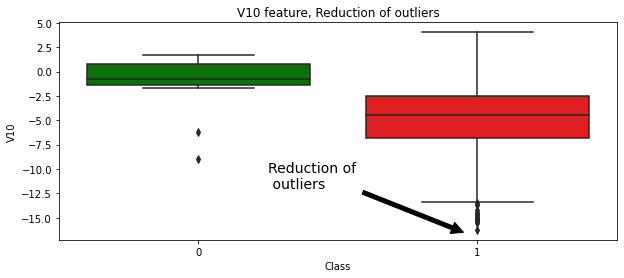

In [27]:
f, ax = plt.subplots(1,1, figsize = (10,4))

sns.boxplot(x= 'Class', y= 'V10' ,data= under_data, palette=['g','r'] , ax= ax)
ax.set_title('V10 feature, Reduction of outliers')
ax.annotate('Reduction of \n outliers', xy=(0.95, -16.5), xytext=(0.25, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

Now we can see the outliers got removed to a great extent, should also need to see the accuracy or precision which ever , considering outliers then we can understand the effect of outliers

## Dimensionality Reduction

t SNE technique to understand the distribution, we cant use PCA because it will only capture the major variance of data irrespective of the clusters whereas tSNE will maintain the variation between different clusters

In [0]:
X_tsne = under_data.drop('Class', axis = 1)
Y_tsne = under_data['Class']

X_reduced_tsne = TSNE(n_components= 2, random_state= 143).fit_transform(X_tsne.values)

X_pca = PCA(n_components= 2, random_state=  143).fit_transform(X_tsne.values)

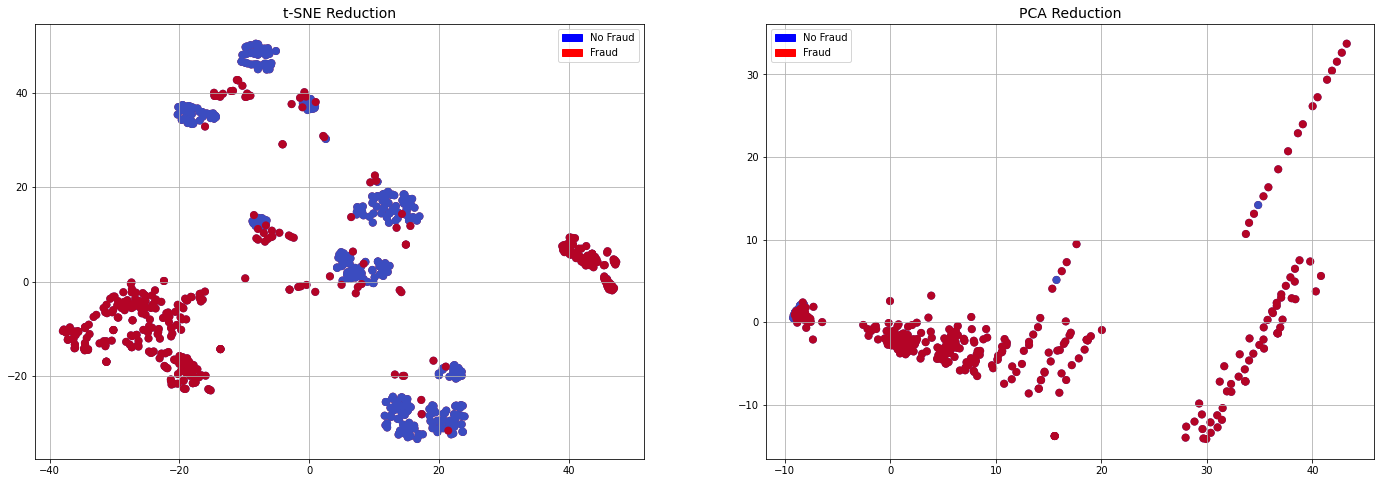

In [29]:
f,ax = plt.subplots(1,2,figsize = (24,8))

no_fraud = mpatches.Patch(color='b', label='No Fraud')
fraud = mpatches.Patch(color='r', label='Fraud')


# t-SNE scatter plot
ax[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_tsne == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_tsne == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax[0].set_title('t-SNE Reduction', fontsize=14)
ax[0].grid(True)
ax[0].legend(handles=[no_fraud, fraud])


# PCA scatter plot
ax[1].scatter(X_pca[:,0], X_pca[:,1], c=(Y_tsne == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax[1].scatter(X_pca[:,0], X_pca[:,1], c=(Y_tsne == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax[1].set_title('PCA Reduction', fontsize=14)
ax[1].grid(True)
ax[1].legend(handles=[no_fraud, fraud])

## Classification Algorithms

In [0]:
#  simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

## Precaution for sampling data

If we are using the undersampled data on cross validation then we are providing synthetic data for validation set which will result in false assumptions, so we need to random sample during cross validation so that validation set will be as real scenario data, then we can get the idea of the model in real scenario, which we will see in oversampling scenario because for undersample we will have less number for training the model if we undersample while cross validation

In [31]:
# Using directly on the undersampled data
for name, classifier in classifiers.items():
  cross_val = cross_val_score(classifier, X_tsne,Y_tsne, cv= 5)
  print('Accuracy of ', name, ' is', cross_val.mean()*100)

Accuracy of  LogisiticRegression  is 95.52631578947368
Accuracy of  KNearest  is 94.73684210526316
Accuracy of  Support Vector Classifier  is 92.63157894736842
Accuracy of  DecisionTreeClassifier  is 95.13157894736842
Accuracy of  RandomForestClassifier  is 97.5


In [32]:
# Using classifiers on dimension reduced data
for name, classifier in classifiers.items():
  cross_val = cross_val_score(classifier, X_reduced_tsne,Y_tsne, cv= 5)
  print('Accuracy of ', name, ' is', cross_val.mean()*100)

Accuracy of  LogisiticRegression  is 70.92105263157895
Accuracy of  KNearest  is 94.73684210526315
Accuracy of  Support Vector Classifier  is 89.73684210526316
Accuracy of  DecisionTreeClassifier  is 94.47368421052632
Accuracy of  RandomForestClassifier  is 95.52631578947368


We can see that for dimension reduced data since the clusters are non linear logistic regression got low accuracy

Below we use gridsearch to find the optimum parameters for all those classifiers

In [0]:
# Grid Search CV

# Use GridSearchCV to find the best parameters.

# Logistic Regression 
lr_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_lr = GridSearchCV(LogisticRegression(), lr_params)
# LR best estimator
grid_lr.fit(X_tsne,Y_tsne)
lr_grid = grid_lr.best_estimator_

#KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
# Knn best estimator
grid_knears.fit(X_tsne,Y_tsne)
knn_grid = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)

# SVC best estimator
grid_svc.fit(X_tsne,Y_tsne)
svc_grid = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
# tree best estimator
grid_tree.fit(X_tsne,Y_tsne)
dtree_grid = grid_tree.best_estimator_

# RandomForest Classifier
rf_params = {'n_estimators': [200,400,600, 1000],
               
              'max_depth': [10,20,30,40],
              
             'min_samples_leaf': [1, 2, 4]
              }
from sklearn.model_selection import RandomizedSearchCV
grid_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params)

# RF best estimator
grid_rf.fit(X_tsne,Y_tsne)
rf_grid = grid_rf.best_estimator_

In [0]:
#  simple classifiers

classifiers_grid = {
    "LogisiticRegression": lr_grid,
    "KNearest": knn_grid,
    "Support Vector Classifier": svc_grid,
    "DecisionTreeClassifier": dtree_grid,
    'RandomForestClassifier': rf_grid
}

In [35]:
for name, classifier in classifiers_grid.items():
  cross_val = cross_val_score(classifier, X_tsne,Y_tsne, cv= 5)
  print('Accuracy of grid search based ', name, ' is', cross_val.mean()*100)

Accuracy of grid search based  LogisiticRegression  is 96.3157894736842
Accuracy of grid search based  KNearest  is 95.13157894736842
Accuracy of grid search based  Support Vector Classifier  is 95.5263157894737
Accuracy of grid search based  DecisionTreeClassifier  is 94.47368421052632
Accuracy of grid search based  RandomForestClassifier  is 97.5


In [0]:
from sklearn.model_selection import learning_curve

def plotting_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    f, ax1 = plt.subplots(1,1, figsize=(8,8), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title((estimator.__class__.__name__," Learning Curve"), fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

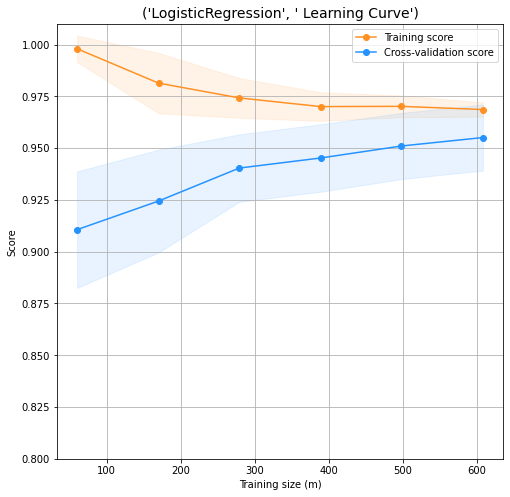

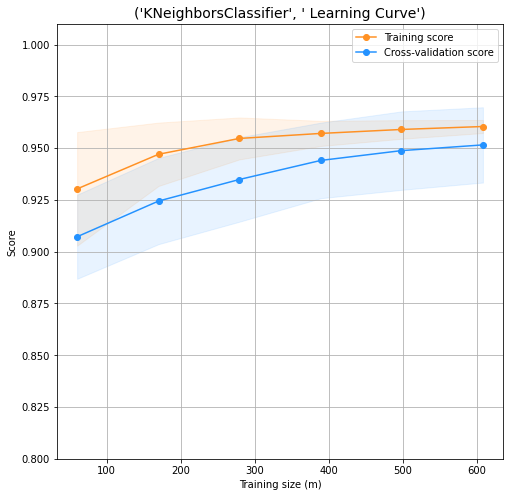

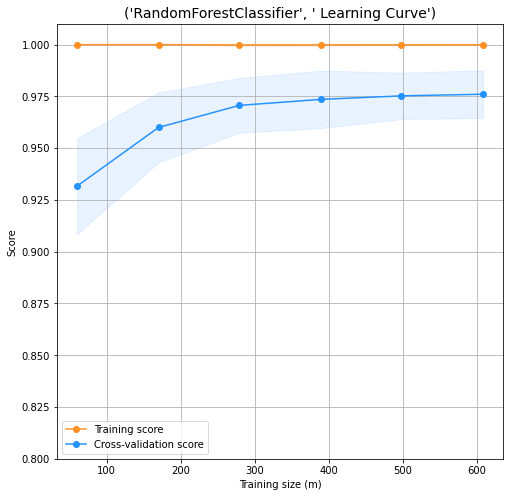

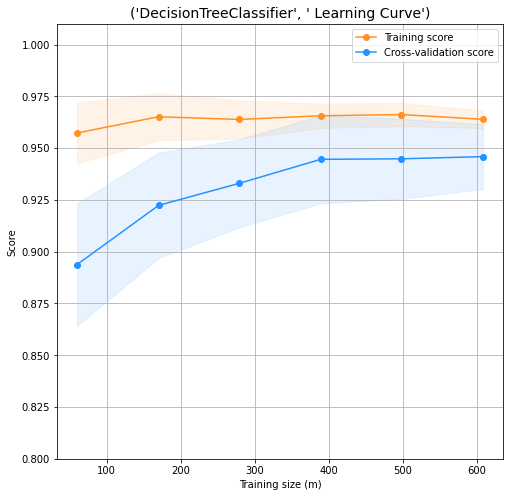

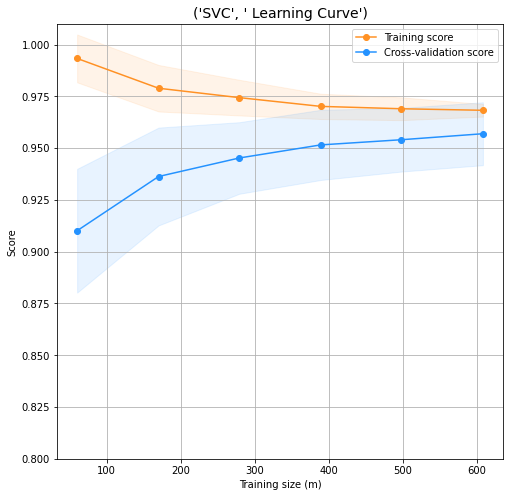

In [37]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=143)
plotting_learning_curve(lr_grid, X_tsne, Y_tsne, (0.80, 1.01), cv=cv, n_jobs=4)
plotting_learning_curve(knn_grid, X_tsne, Y_tsne, (0.80, 1.01), cv=cv, n_jobs=4)
plotting_learning_curve(RandomForestClassifier(), X_tsne, Y_tsne, (0.80, 1.01), cv=cv, n_jobs=4)
plotting_learning_curve(dtree_grid, X_tsne, Y_tsne, (0.80, 1.01), cv=cv, n_jobs=4)
plotting_learning_curve(svc_grid, X_tsne, Y_tsne, (0.80, 1.01), cv=cv, n_jobs=4)

In [0]:
# precision recall f1score 
def metrics_evaluate(estimator, y_true, x_test,sampled_data):
  x_train = sampled_data.drop('Class', axis = 1)
  y_train = sampled_data['Class']
  estimator.fit(x_train, y_train)
  y_pred = estimator.predict(x_test)
  print('Recall score of ', estimator.__class__.__name__, ' for test set:', recall_score(y_true, y_pred))
  print('Precision score of ', estimator.__class__.__name__, ' for test set:', recall_score(y_true, y_pred))
  print('Roc score of ', estimator.__class__.__name__, ' for test set:', roc_auc_score(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(1, 1,figsize=(8,6))


  sns.heatmap(cm, ax=ax, annot=True, cmap=plt.cm.copper)
  ax.set_title((estimator.__class__.__name__," \n Confusion Matrix"), fontsize=14)
  ax.set_xticklabels(['Pred true', 'Pred False'], fontsize=14, rotation=90)
  ax.set_yticklabels(['True True', 'True False'], fontsize=14, rotation=360) 

Recall score of  LogisticRegression  for test set: 0.9252336448598131
Precision score of  LogisticRegression  for test set: 0.9252336448598131
Roc score of  LogisticRegression  for test set: 0.7310716636927682
Recall score of  DecisionTreeClassifier  for test set: 0.9345794392523364
Precision score of  DecisionTreeClassifier  for test set: 0.9345794392523364
Roc score of  DecisionTreeClassifier  for test set: 0.6237579282269949
Recall score of  SVC  for test set: 0.8878504672897196
Precision score of  SVC  for test set: 0.8878504672897196
Roc score of  SVC  for test set: 0.7535637878617274
Recall score of  KNeighborsClassifier  for test set: 0.9252336448598131
Precision score of  KNeighborsClassifier  for test set: 0.9252336448598131
Roc score of  KNeighborsClassifier  for test set: 0.738441288176103
Recall score of  RandomForestClassifier  for test set: 0.9532710280373832
Precision score of  RandomForestClassifier  for test set: 0.9532710280373832
Roc score of  RandomForestClassifier 

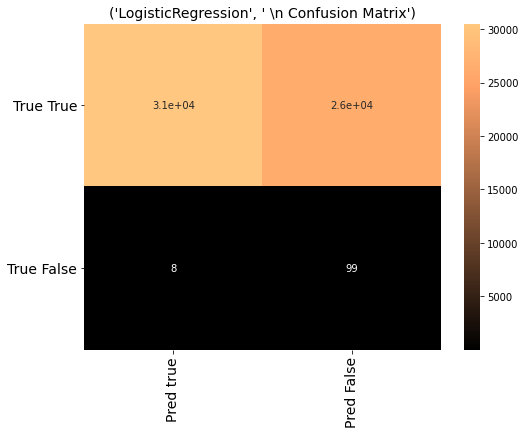

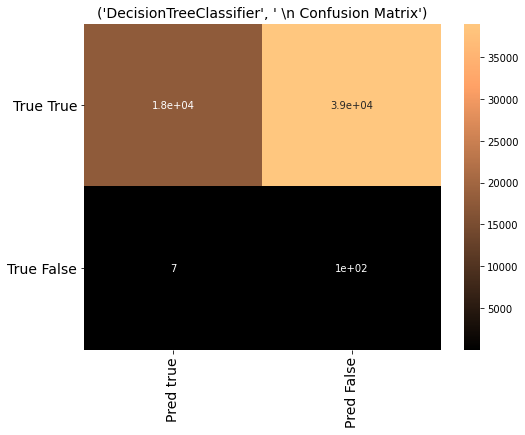

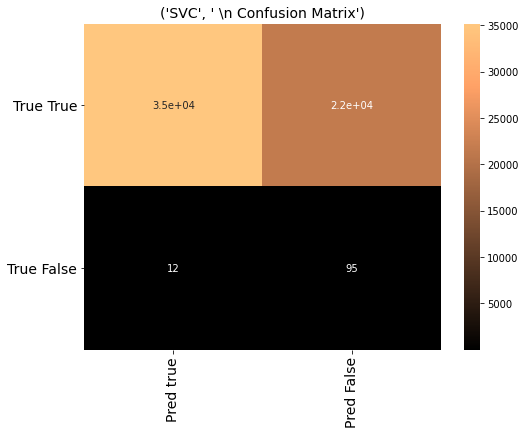

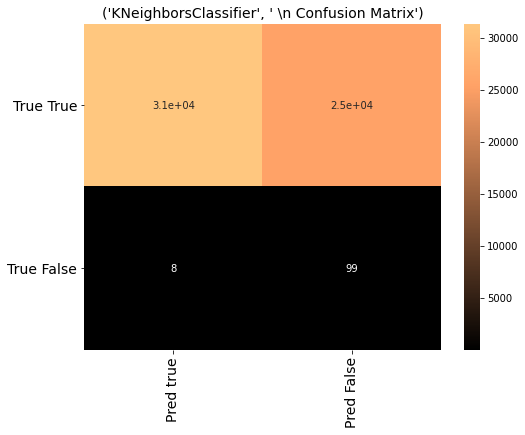

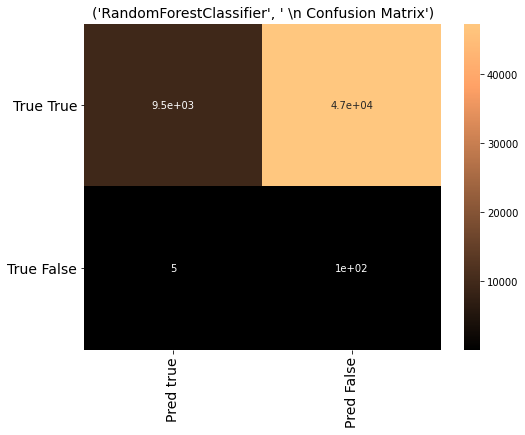

In [39]:
metrics_evaluate(lr_grid, Y_test_org, X_test_org,under_data)
metrics_evaluate(dtree_grid, Y_test_org, X_test_org,under_data)
metrics_evaluate(svc_grid, Y_test_org, X_test_org,under_data)
metrics_evaluate(knn_grid, Y_test_org, X_test_org,under_data)
metrics_evaluate(rf_grid, Y_test_org, X_test_org,under_data)

# Oversampling Technique

In [0]:
X_train_org = X_train_org.reset_index(drop= True)
Y_train_org = Y_train_org.reset_index(drop = True)

In [103]:

print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train_org), len(Y_train_org)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test_org), len(Y_test_org)))

# List to append the score and then find the average
accuracy_lr = [];accuracy_svc = [];accuracy_knn = [];accuracy_dtree = [];accuracy_rf = []
precision_lr = [];precision_knn = [];precision_svc = [];precision_dtree = [];precision_rf = []
recall_lr = [];recall_knn = [];recall_svc = [];recall_dtree = [];recall_rf = []
f1_lr = [];f1_knn = [];f1_svc = [];f1_dtree = [];f1_rf = []
auc_lr = [];auc_knn = [];auc_dtree = [];auc_svc = [];auc_rf = []
# Logistic Regression 
lr_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_lr = RandomizedSearchCV(LogisticRegression(), lr_params, n_iter=4)


#KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = RandomizedSearchCV(KNeighborsClassifier(), knears_params, n_iter=4)


# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = RandomizedSearchCV(SVC(), svc_params, n_iter=4)


# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, n_iter=4)

# RandomForest Classifier
rf_params = {'n_estimators': [200,400,600, 1000],
               
              'max_depth': [10,20,30,40],
              
             'min_samples_leaf': [1, 2, 4]
              }

grid_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=4)


# Implementing SMOTE Technique 
# Sampling while Cross Validation
# Parameters

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train, test in sss.split(X_train_org, Y_train_org):
    #abc = grid_lr.fit(X_train_org.iloc[train], Y_train_org[train])
    pipeline = imbalanced_pipeline([('smote',SMOTE(sampling_strategy='minority')),('classifier', grid_rf)]) # SMOTE happens during Cross Validation not before..
    #gridlr = RandomizedSearchCV(pipeline,  lr_params)
    model = pipeline.fit(X_train_org.iloc[train], Y_train_org[train])
    best_est = grid_lr.best_estimator_
    prediction = best_est.predict(X_train_org.iloc[test])
    
    accuracy_lr.append(accuracy_score(Y_train_org[test], prediction))
    precision_lr.append(precision_score(Y_train_org[test], prediction))
    recall_lr.append(recall_score(Y_train_org[test], prediction))
    f1_lr.append(f1_score(Y_train_org[test], prediction))
    auc_lr.append(roc_auc_score(Y_train_org[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lr)))
print("precision: {}".format(np.mean(precision_lr)))
print("recall: {}".format(np.mean(recall_lr)))
print("f1: {}".format(np.mean(f1_lr)))
print("roc: {}".format(np.mean(auc_lr)))
print('---' * 45)

Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962


KeyboardInterrupt: ignored

In [0]:

sm = SMOTE(ratio='minority', random_state=143)



# This will be the data were we are going to use for NN 
Xsm_train, ysm_train = sm.fit_sample(X_train_org, Y_train_org)

In [0]:
rf_grid_os = grid_rf.fit(Xsm_train,ysm_train).best_estimator_


In [0]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
os_pred_rf = rf_grid_os.predict(X_test_org)
os_rf_cm = confusion_matrix(Y_test_org, os_pred_rf)
actual_cm = confusion_matrix(Y_test_org, Y_test_org)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(os_rf_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Even in oversampling we can see that precision is very less, which means non fraud cases were also been considered as fraud, now we shall see how NN will work

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_tsne.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [0]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [101]:
undersample_model.fit(X_tsne, Y_tsne, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 608 samples, validate on 152 samples
Epoch 1/20
 - 0s - loss: 1.4016 - accuracy: 0.5806 - val_loss: 0.5701 - val_accuracy: 0.5658
Epoch 2/20
 - 0s - loss: 0.5726 - accuracy: 0.7697 - val_loss: 0.4839 - val_accuracy: 0.8026
Epoch 3/20
 - 0s - loss: 0.4479 - accuracy: 0.9128 - val_loss: 0.3616 - val_accuracy: 0.8026
Epoch 4/20
 - 0s - loss: 0.4204 - accuracy: 0.9046 - val_loss: 0.3627 - val_accuracy: 0.8026
Epoch 5/20
 - 0s - loss: 0.3999 - accuracy: 0.9145 - val_loss: 0.3653 - val_accuracy: 0.8026
Epoch 6/20
 - 0s - loss: 0.3845 - accuracy: 0.9227 - val_loss: 0.3189 - val_accuracy: 0.8092
Epoch 7/20
 - 0s - loss: 0.3629 - accuracy: 0.9243 - val_loss: 0.3364 - val_accuracy: 0.8026
Epoch 8/20
 - 0s - loss: 0.3490 - accuracy: 0.9243 - val_loss: 0.3360 - val_accuracy: 0.8026
Epoch 9/20
 - 0s - loss: 0.3387 - accuracy: 0.9243 - val_loss: 0.3467 - val_accuracy: 0.8026
Epoch 10/20
 - 0s - loss: 0.3293 - accuracy: 0.9243 - val_loss: 0.3522 - val_accuracy: 0.8026
Epoch 11/20
 - 0s - los

In [102]:
undersample_fraud_predictions = undersample_model.predict_classes(X_test_org, batch_size=200, verbose=0)

ValueError: ignored

Confusion matrix, without normalization
[[20520 36335]
 [   10    97]]
Confusion matrix, without normalization
[[56855     0]
 [    0   107]]


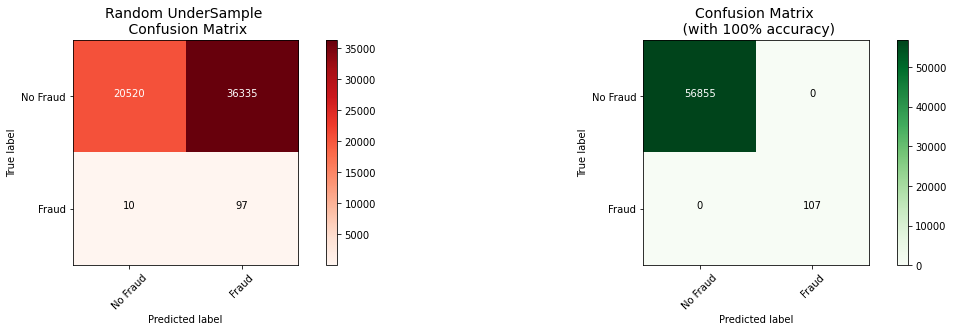

In [96]:
undersample_cm = confusion_matrix(Y_test_org, undersample_fraud_predictions)
actual_cm = confusion_matrix(Y_test_org, Y_test_org)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [0]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [89]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363936 samples, validate on 90984 samples
Epoch 1/20
 - 2s - loss: 0.0646 - accuracy: 0.9773 - val_loss: 0.0265 - val_accuracy: 0.9942
Epoch 2/20
 - 2s - loss: 0.0124 - accuracy: 0.9974 - val_loss: 0.0120 - val_accuracy: 0.9996
Epoch 3/20
 - 2s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/20
 - 2s - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0046 - val_accuracy: 0.9996
Epoch 5/20
 - 2s - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/20
 - 2s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9999
Epoch 7/20
 - 2s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 8/20
 - 2s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 3.8942e-04 - val_accuracy: 1.0000
Epoch 9/20
 - 2s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 4.9716e-04 - val_accuracy: 1.0000
Epoch 10/20
 - 2s - loss: 0.0019 - accuracy: 0.9997 - val_loss: 9.2579e-04 - val_accuracy: 1.0000
Epoch 

Confusion matrix, without normalization
[[56825    30]
 [   21    86]]
Confusion matrix, without normalization
[[56855     0]
 [    0   107]]


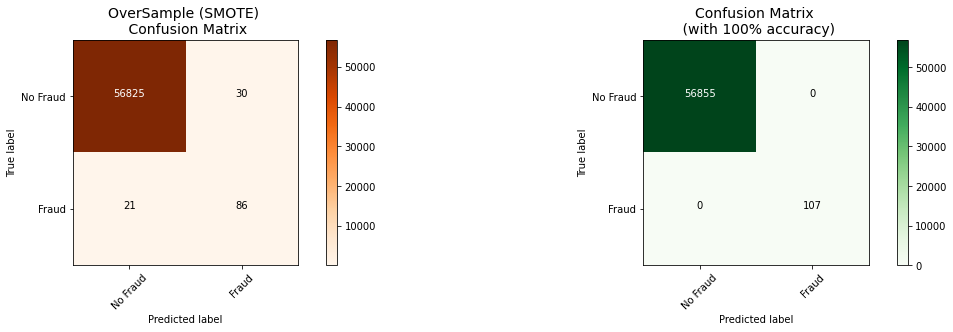

In [91]:
oversample_fraud_predictions = oversample_model.predict_classes(X_test_org, batch_size=200, verbose=0)
oversample_smote = confusion_matrix(Y_test_org, oversample_fraud_predictions)
actual_cm = confusion_matrix(Y_test_org, Y_test_org)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# Conclusion

Neural Network seem to work best for oversampled data, because NN needs more data for training it doesnot seem to work good for undersampled data, more non fraud cases are categorized as fraud.

Random Forest worked good in traditional machine learning algorithms, but in all of the cases model failed to classify most of the non fraud cases but NN seem to work good in that scenario with the usage of over sampling